## Graph Neural Network Property Predictor


## Imports

In [1]:
# Main Imports
import torch
import random
import numpy as np

# Profiling
import cProfile
import pstats
from pstats import SortKey

# Import Local Files
from model import GNN
from utils.config import FEATURE_NAMES, RESIDUAL_G_FEATURES
import utils.data_utils as DataUtils
import utils.visualization as Visualization

c:\Users\Will\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Execution

In [2]:
# Profile the main training routine
# profiler = cProfile.Profile()
# profiler.enable()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# For reference
"""
GRAPH_METRICS = [
    "Density",
    "AvgClustering",
    "AvgPathLength",
    "DegreeAssortativity",
    "Transitivity",
    "ConnectedComponents",
    "MaxDegree",
    "MinDegree",
    "AvgDegree",
    "GlobalEfficiency"
]
"""

# Select target feature for analysis
target_feature = "GMinus_" + "AvgPathLength"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

# Generate different graphs for training and test to test generalization
print("Generating graphs...")
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=100, edge_prob=0.2)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=100, edge_prob=0.2)

print(f"Train graph: {len(G_train)} nodes, {G_train.number_of_edges()} edges")
print(f"Test graph: {len(G_test)} nodes, {G_test.number_of_edges()} edges")

print("\nProcessing graph data...")
train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

# Initialize Model
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
print(f"FEATURE_NAMES length: {len(FEATURE_NAMES)}")

# Make sure the dimensions match
if node_feature_dim != len(FEATURE_NAMES):
    print(f"Warning: Feature dimension mismatch! Expected {len(FEATURE_NAMES)}, got {node_feature_dim}")

model = GNN(node_feature_dim=len(FEATURE_NAMES))
# print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Train model
print("\nTraining model...")
losses, trained_model, feature_stats = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate elapsed time and profiling results
# profiler.disable()
# print("\nProfiling Results:")
# stats = pstats.Stats(profiler).sort_stats(SortKey.TIME)
# stats.print_stats(20)  # Show top 20 time-consuming functions



Generating graphs...
Train graph: 100 nodes, 976 edges
Test graph: 100 nodes, 1034 edges

Processing graph data...

Initializing model...
Node feature dimension: 11
FEATURE_NAMES length: 11

Training model...

Training Progress:
Epoch 0: Train Loss = 2.3564e-01, Test Loss = 1.9294e-01
Epoch 1: Train Loss = 2.0320e-01, Test Loss = 1.6659e-01
Epoch 2: Train Loss = 1.7400e-01, Test Loss = 1.3913e-01
Epoch 3: Train Loss = 1.4634e-01, Test Loss = 1.1508e-01
Epoch 4: Train Loss = 1.2342e-01, Test Loss = 9.2866e-02
Epoch 5: Train Loss = 9.8218e-02, Test Loss = 7.3980e-02
Epoch 6: Train Loss = 7.9994e-02, Test Loss = 5.7493e-02
Epoch 7: Train Loss = 6.3691e-02, Test Loss = 4.3675e-02
Epoch 8: Train Loss = 5.0274e-02, Test Loss = 3.1125e-02
Epoch 9: Train Loss = 3.7382e-02, Test Loss = 2.0417e-02
Epoch 10: Train Loss = 2.5697e-02, Test Loss = 1.3698e-02
Epoch 11: Train Loss = 1.7487e-02, Test Loss = 7.7148e-03
Epoch 12: Train Loss = 1.1388e-02, Test Loss = 3.3772e-03
Epoch 13: Train Loss = 6.49

## Visualization

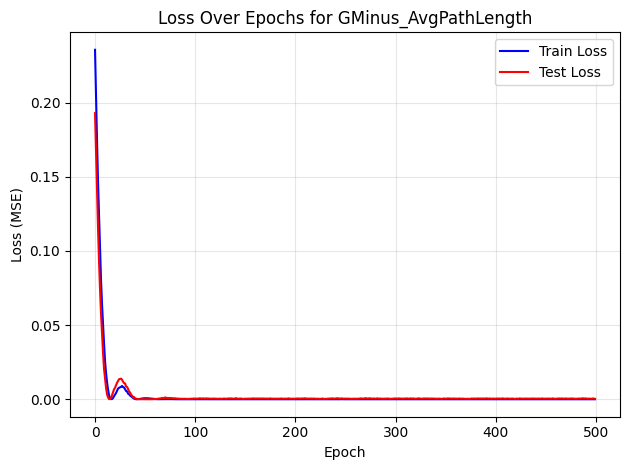


Model Predictions Analysis:
Using 500 sampled target values from training
Average prediction: 0.827842
Average actual value: 0.833360
Std dev of actual values: 0.000000
Average absolute error: 0.005517
Standard deviation of predictions: 0.052478


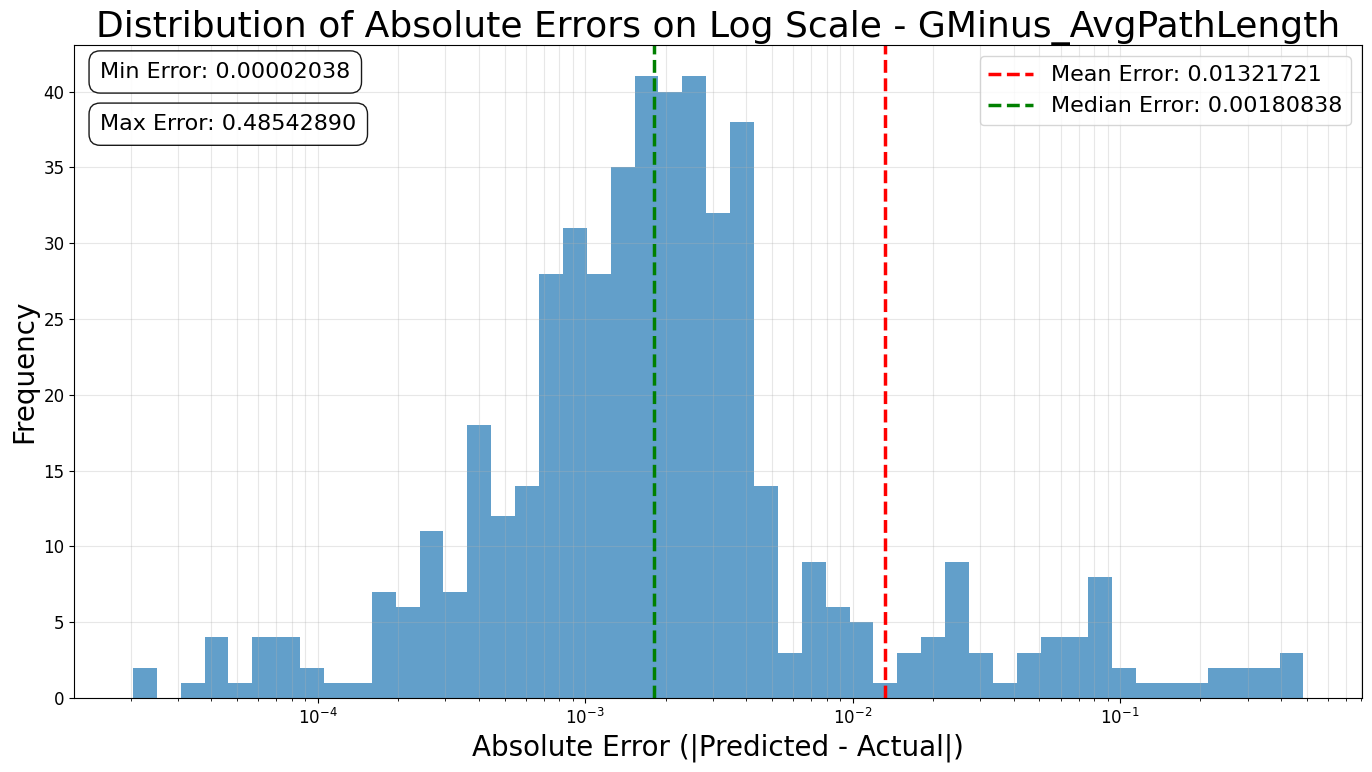


=== Node Feature Statistics ===
                 Feature     Mean      Min      Max  Std Dev  Variance  All Identical
      Node_Metric_Degree 0.650667 0.300000 1.000000 0.135686  0.018411          False
  Node_Metric_Clustering 0.200884 0.106061 0.305556 0.036151  0.001307          False
 Node_Metric_NeighborDeg 0.679499 0.609524 0.766667 0.029766  0.000886          False
 Node_Metric_Betweenness 0.086683 0.000442 0.345173 0.077755  0.006046          False
   Node_Metric_Closeness 5.502207 4.950000 5.892857 0.168482  0.028386          False
    Node_Metric_PageRank 0.100000 0.055831 0.144271 0.017067  0.000291          False
  Node_Metric_CoreNumber 0.993846 0.692308 1.000000 0.035551  0.001264          False
    Node_Metric_LocalEff 0.320216 0.263636 0.383333 0.020513  0.000421          False
 Node_Metric_Eigenvector 0.977521 0.453679 1.510626 0.210840  0.044453          False
Node_Metric_LocalDensity 0.281743 0.214286 0.444444 0.036168  0.001308          False
  Node_Metric_IsSelec

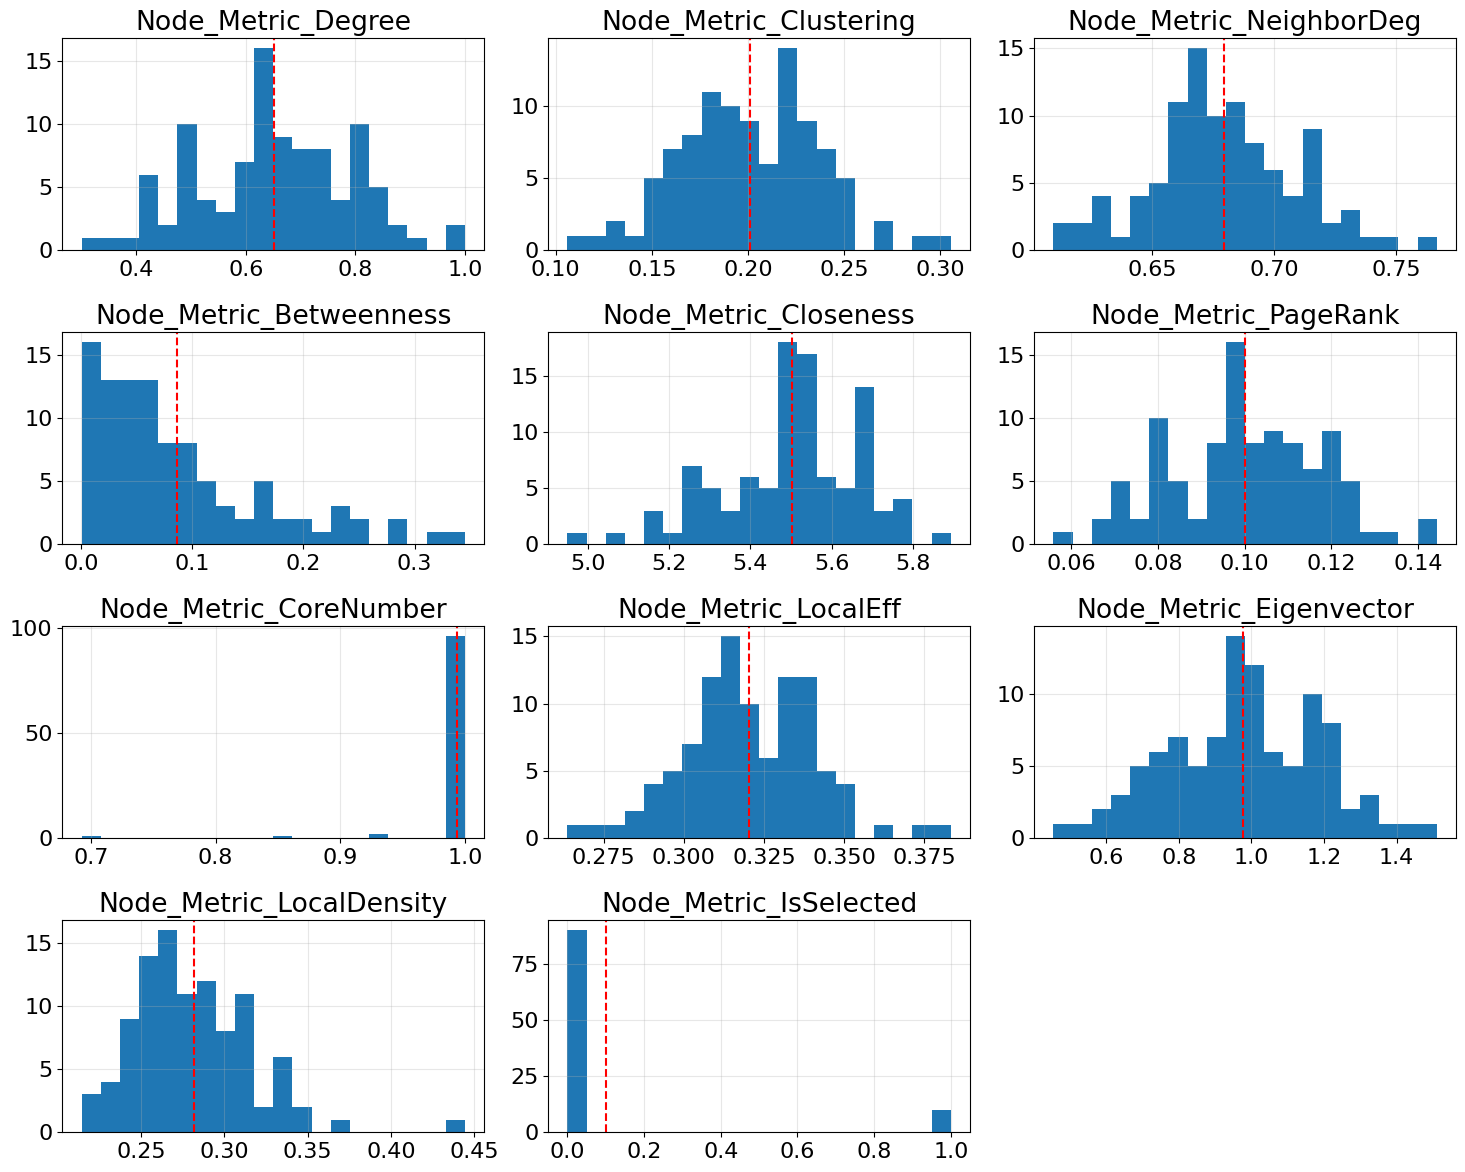


Performing PCA on node features...
Using raw node features

PCA Explained Variance:
  PC1: 88.91% (Cumulative: 88.91%)
  PC2: 5.14% (Cumulative: 94.05%)
  PC3: 3.44% (Cumulative: 97.49%)

Feature Contributions to Top Components:
                               PC1       PC2
Node_Metric_Eigenvector   0.692177 -0.201043
Node_Metric_Closeness     0.549755  0.041504
Node_Metric_Degree        0.445816  0.020493
Node_Metric_Betweenness   0.105556  0.944022
Node_Metric_LocalDensity -0.056165 -0.133423
Node_Metric_PageRank      0.055889  0.007567
Node_Metric_CoreNumber    0.049734  0.004983
Node_Metric_Clustering    0.003649 -0.121805
Node_Metric_LocalEff      0.001242 -0.087217
Node_Metric_NeighborDeg   0.000335 -0.161044


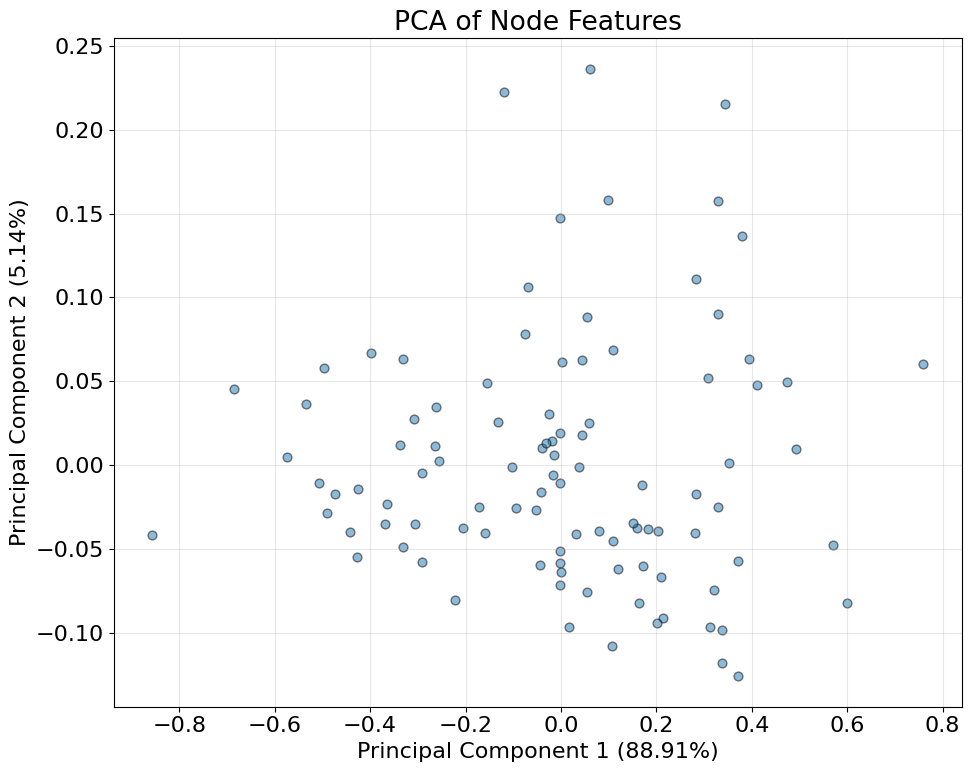

In [3]:
# Do visualization
Visualization.visualize_results(losses, trained_model, test_data, target_feature, feature_stats)
# Visualization.visualize_feature_redundancy(feature_stats)
feature_stats_df = Visualization.visualize_feature_statistics(train_data, show_histograms=True)
# Visualization.visualize_feature_pairs(train_data, num_pairs=15, prioritize_variance=True, use_node_features=True)
pca, components = Visualization.visualize_pca(train_data, n_components=3, use_node_features=True)